In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

!which python

/opt/homebrew/anaconda3/envs/aiml/bin/python



# Lab 2: Application of Reinforcement Learning (DQN)
**Author**: [Adam Paszke](https://github.com/apaszke)
            [Mark Towers](https://github.com/pseudo-rnd-thoughts)
            Jingsai Liang


This lab is to use PyTorch to train a Deep Q Learning (DQN) agent
on a task from [Gymnasium](https://www.gymnasium.farama.org)_.

**Task**

Please visit this page (https://gymnasium.farama.org/environments/box2d/lunar_lander/) to read the full description of the game *Lunar Lander* and answe following questions.

You also can play this game online here:
http://moonlander.seb.ly/







Question 1: What observations can the agent collect at each step of the game?

coordinate pair of (x,y), linear velocities in x and y directors, angle, angular velcoty, and if the legs are both on the ground

Question 2: What actions can the agent take after receving the observation?

Fire left, fire right, fire up, or fire nothing

Question 3: What rewards do the agent receive during the game?

distance from landing pad, speed (x and y) of rocket ship, rocket ship angle, leg contact, which engine is firing

Question 4: When will the game terminate or truncate?

When the rocket ship lands or crashes or is outside the viewport

**Packages**

First, let's import needed packages. Firstly, we need
[gymnasium](https://gymnasium.farama.org/)_ for the environment,
installed by using `pip`. This is a fork of the original OpenAI
Gym project and maintained by the same team since Gym v0.19.
If you are running this in Google colab, run:

In [2]:
%%bash
pip3 install gymnasium[box2d]

We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)


In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("LunarLander-v3")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


## Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN

Now, let's define our model.

You need to define and change the structure of your network
for training a better result such as:
  
- number of layers
- number of neurons on layers
- activation functions



In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output_layer(x)

## Training

### Hyperparameters



In [6]:
"""You need to initialize these hyperparameters to tune your training.
Replace None by numbers.
"""

# Total number of episodes for training
num_episodes = 300
# BATCH_SIZE is the number of transitions sampled from the replay buffer
BATCH_SIZE = 64
# GAMMA is the discount factor as mentioned in the previous section
GAMMA = .99
# LR is the learning rate of the AdamW optimizer
LR = 1e-3
# Size of the replay memory
MEMORY_SIZE = 10000
# TAU is the update rate of the target network
TAU = 0.005

# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 500

### Utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_rewards`` - a helper for plotting the rewards of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.


In [7]:
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_rewards = []
def plot_rewards(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training loop

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network is updated at every step with a
[soft update](https://arxiv.org/pdf/1509.02971.pdf)_ controlled by
the hyperparameter ``TAU``, which was previously defined.




In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    # print("here",batch.state[0])

    state_batch = torch.cat(batch.state) # stack the state vertically row by row. the size is 128*4.
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # print(state_batch.shape)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial ``state`` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Training RL agents can be a noisy process, so restarting training
can produce better results if convergence is not observed.




**Warning**

The training may take hours to finish. It it better to add some code below to *periodically* save your model, in case your colab is disconnected and you can load your model and resume the training.

The instructions of saving and loading models is in next section.

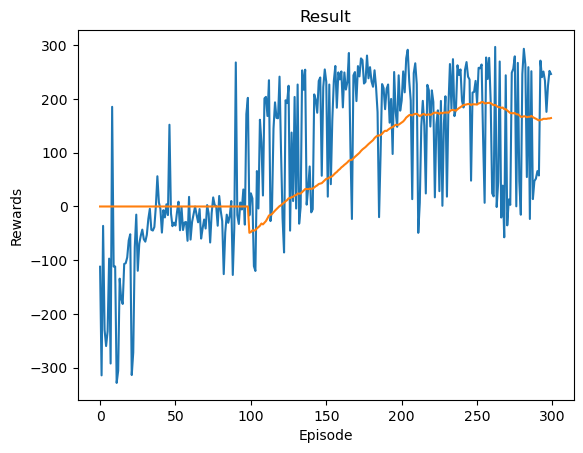

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    total_rewards = 0
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    while True:
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        total_rewards += reward

        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(total_rewards)
            plot_rewards()
            break



print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()

You are expected to see a training picture like the one below. It shows that after running 1500 episodes, the model becomes stable around the rewards of 200 points.

![](https://cs.westminstercollege.edu/~jingsai/courses/CMPT301/assignments/lunarlander/model2_training.png)

## Save and load model

Do not forget to save your model to your own goodle drive if you get a good model. Otherwise, you need to train your network again to get it.

Before saving your mode, you need to run the code below to mount your drive to this notebook.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Force to mount again even though the drive has been already mounted.
# drive.mount('/content/drive',force_remount=True)

# disconnect the mount
# drive.flush_and_unmount()


### Save model

Change the last filename in the path to save it.

In [11]:
#torch.save(policy_net, '/content/drive/My Drive/Colab Notebooks/model.pth')

torch.save(policy_net.state_dict(), 'lunar_lander_model.pth')

torch.save({
    'model_state_dict': policy_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'lunar_lander_checkpoint.pth')

### Load model

Load your model without training the network. You need to make sure that the structure of the network you defined earlier in this notebook must match the model you are loading here.

If the model was trained in GPU while the running time is CPU now, you need to add `map_location=torch.device('cpu')` in `torch.load` to change the device.

In [12]:
#policy_net = torch.load('/content/drive/My Drive/Colab Notebooks/model.pth')

policy_net.load_state_dict(torch.load('lunar_lander_model.pth', weights_only=True))
policy_net.eval()

checkpoint = torch.load('lunar_lander_checkpoint.pth', weights_only=True)
policy_net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Testing

### Testing through animation

You should see a video showing lunar lander successfully landed on the moon!

In [13]:
# For visualization and analysis
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython import display
import io, base64

In [14]:
def select_action_testing(state):
    with torch.no_grad():
        return policy_net(state).max(1)[1].view(1, 1)

def show_video(video_name):
    file = '{}.mp4'.format(video_name)
    mp4 = open(file,'rb').read()
    data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
    display.display(HTML("""
    <video height: 400px controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url))

In [15]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder="./")

obs, info = env.reset()
while True:
    obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    action = select_action_testing(obs)
    obs, reward, terminated, truncated, info = env.step(action.item())

    if terminated or truncated:
        break

env.close()

/opt/homebrew/anaconda3/envs/aiml/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/makennaworley/Library/CloudStorage/OneDrive-Personal/Desktop/Undergrad Westminster/CMPT 301 Artificial Intelligence/lab2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


The video is saved in a temporary folder. You can permanently save it in your google drive.

In [16]:
show_video("rl-video-episode-0")

You are expected to see a video like this:

In [17]:
%%html
<iframe width="500" height="350" src="https://cs.westminstercollege.edu/~jingsai/courses/CMPT301/assignments/lunarlander/model_video.mp4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>


### Testing through statistics

Run your agent 1000 times of episodes.

An episode is considered a solution if it scores at least 200 points.

Calculate the average rewards and the percetage of solutions.

In [18]:
total_rewards_list = []

for i in range(1000):
    env = gym.make("LunarLander-v3")
    obs, info = env.reset()
    total_rewards = 0
    while True:
        obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action_testing(obs)
        obs, reward, terminated, truncated, info = env.step(action.item())

        total_rewards += reward

        if terminated or truncated:
            break
    if not i%100:
        print(i, "/1000 completed.")

    total_rewards_list.append(total_rewards)
    env.close()

0 /1000 completed.
100 /1000 completed.
200 /1000 completed.
300 /1000 completed.
400 /1000 completed.
500 /1000 completed.
600 /1000 completed.
700 /1000 completed.
800 /1000 completed.
900 /1000 completed.


**Goal**

Your lab is considered perfect if the average rewards is larger than 200 and the percentage of solutions is larger than 50%.

In [19]:
# average rewards
np.mean(total_rewards_list)

np.float64(220.0132358795485)

In [20]:
# percentage of solutions
np.sum(np.array(total_rewards_list)>=200)/1000

np.float64(0.842)

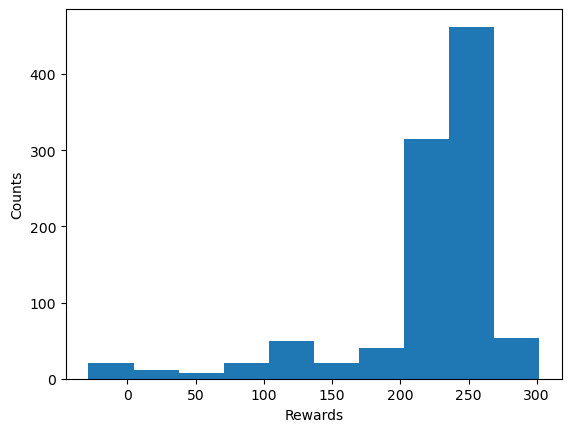

In [21]:
# histogram of rewards
plt.hist(total_rewards_list)
plt.xlabel("Rewards")
plt.ylabel("Counts")
plt.show()

You are expected to see a histogram like this:

![](https://cs.westminstercollege.edu/~jingsai/courses/CMPT301/assignments/lunarlander/model_hist.png)

## Submission

You need to submit both

- source code
- a saved model